In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load raw alias data
file_path = '/content/drive/MyDrive/lung_cancer_genes.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print("✅ File loaded successfully!")
print(raw_text[:500])  # Just preview first 500 chars

✅ File loaded successfully!
TERT	CMM9, DKCA2, DKCB4, EST2, PFBMFT1, TCS1, TP2, TRT, hEST2, hTRT
TP63	AIS, B(p51A), B(p51B), EEC3, KET, LMS, NBP, OFC8, RHS, SHFM4, TP53CP, TP53L, TP73L, p40, p51, p53CP, p63, p73H, p73L
MALAT1	HCN, LINC00047, NCRNA00047, NEAT2, PRO2853, mascRNA
EPB41L3	4.1B, DAL-1, DAL1
CHRNA5	LNCR2
CHRNA3	LNCR2, NACHRA3, PAOD2
CLPTM1L	CRR9
BAG6	BAG-6, BAT3, D6S52E, G3
CXCL8	GCP-1, GCP1, IL8, LECT, LUCT, LYNAP, MDNCF, MONAP, NAF, NAP-1, NAP1
Epb41l3	4.1B, DAL1P, Dal1, Epb4.1l3, NBL3
FAM57A	CT120
Malat1	22104


In [ ]:
import re
from collections import defaultdict

# Load the raw aliases text
file_path = '/content/drive/MyDrive/lung_cancer_genes.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Normalize weird characters (accents, extra spaces, etc.)
raw_text = raw_text.replace("–", "-").replace("—", "-").replace(" ", " ")

# Split by newlines
lines = [line.strip() for line in raw_text.split("\n") if line.strip()]

gene_map = defaultdict(list)
current_gene = None

for line in lines:
    # Match main gene + its aliases separated by tab, colon, or space
    if "\t" in line or ":" in line:
        parts = re.split(r'[\t:]', line, maxsplit=1)
        main_gene = parts[0].strip().upper()
        aliases = re.split(r'[,;/]+', parts[1]) if len(parts) > 1 else []
        aliases = [a.strip().upper() for a in aliases if a.strip()]
        gene_map[main_gene].extend(aliases)
        current_gene = main_gene
    else:
        # Continuation of aliases for the previous main gene
        if current_gene:
            aliases = re.split(r'[,;/]+', line)
            aliases = [a.strip().upper() for a in aliases if a.strip()]
            gene_map[current_gene].extend(aliases)

# Convert defaultdict → dict
gene_map = dict(gene_map)

# 🔍 Display summary
print(f"✅ Total main genes: {len(gene_map)}\n")
for k, v in list(gene_map.items())[:5]:
    print(f"{k}: {v}")


✅ Total main genes: 945

TERT: ['CMM9', 'DKCA2', 'DKCB4', 'EST2', 'PFBMFT1', 'TCS1', 'TP2', 'TRT', 'HEST2', 'HTRT']
TP63: ['AIS', 'B(P51A)', 'B(P51B)', 'EEC3', 'KET', 'LMS', 'NBP', 'OFC8', 'RHS', 'SHFM4', 'TP53CP', 'TP53L', 'TP73L', 'P40', 'P51', 'P53CP', 'P63', 'P73H', 'P73L']
MALAT1: ['HCN', 'LINC00047', 'NCRNA00047', 'NEAT2', 'PRO2853', 'MASCRNA', '2210401K01RIK', '9430072K23RIK', 'AI647968', 'NEAT2']
EPB41L3: ['4.1B', 'DAL-1', 'DAL1', '4.1B', 'DAL1P', 'DAL1', 'EPB4.1L3', 'NBL3']
CHRNA5: ['LNCR2']


Loaded Samples: 96 | Genes: 6672
Train/Test Split: (72, 6672) | (24, 6672)
Significant Genes Retained: 1769

 SVM Model Performance:
Accuracy: 1.0000
ROC AUC: 1.0000

 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
      Cancer       1.00      1.00      1.00        21

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



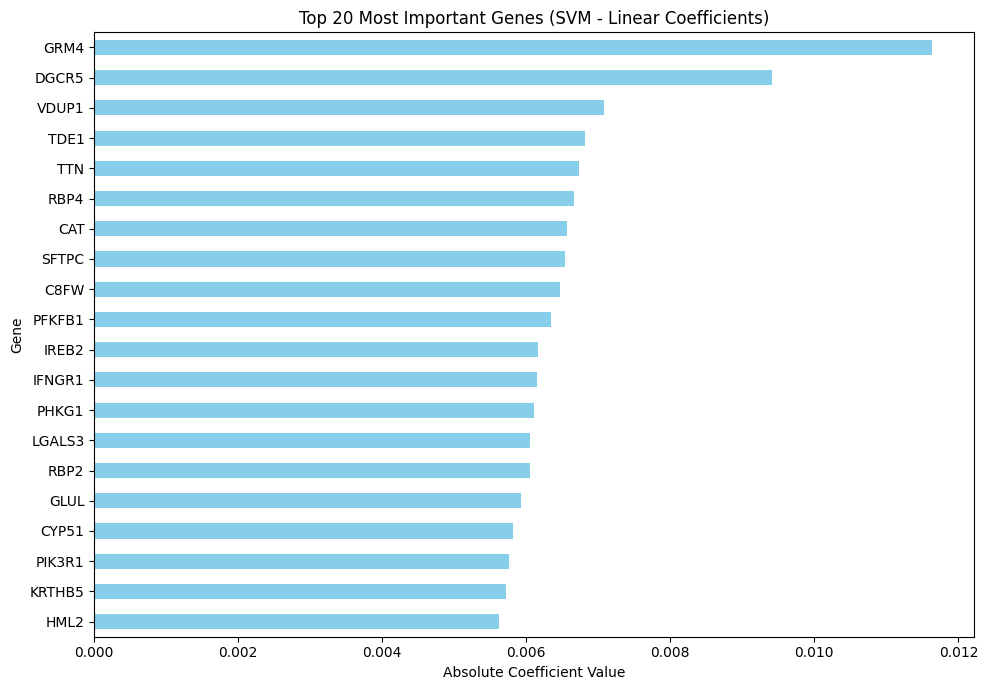


 Top 10 Predicted Cancer-Mediating Genes:
['GRM4', 'DGCR5', 'VDUP1', 'TDE1', 'TTN', 'RBP4', 'CAT', 'SFTPC', 'C8FW', 'PFKFB1']
BIOLOGICAL VALIDATION REPORT (ALIAS-COLLAPSED)

Known Cancer Genes (Canonical): 945
Predicted Genes (Canonical): 1767
Matched Known Genes (Canonical): 261
Accuracy (Matched/Predicted): 14.77%
Coverage (Matched/Reference): 27.62%

 Debug Stats:
Total Predicted Genes: 1767
Total Known Cancer Genes: 945
Total Genes in Dataset: 5615
Sanity Check Passed: 5615 genes fully partitioned

FINAL GENE LABEL EVALUATION 

True Positives (TP): 261
False Positives (FP): 1506
False Negatives (FN): 388
True Negatives (TN): 3460
Accuracy: 66.27%
Precision: 14.77%
Recall: 40.22%
F1 Score: 21.61%


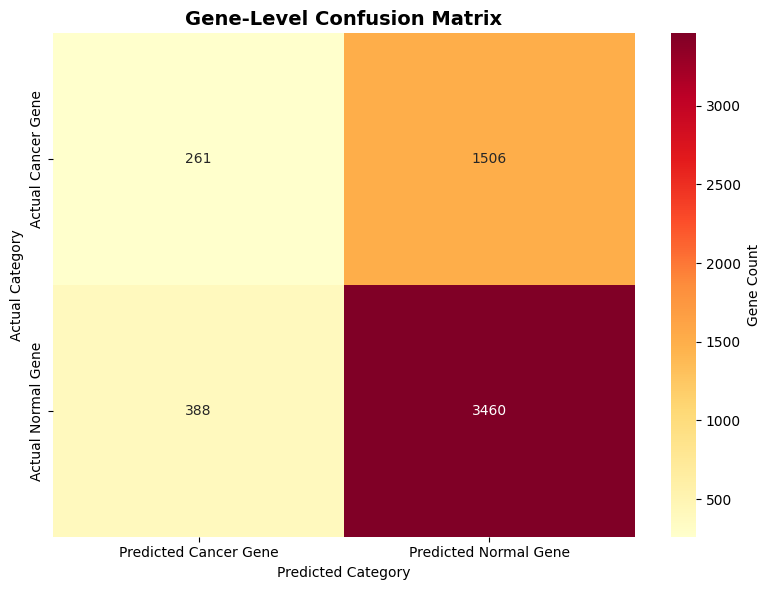

In [2]:
# SUPPORT VECTOR MACHINE (SVM) for Cancer Gene Discovery

!pip install openpyxl --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import SVC
import seaborn as sns
import warnings, re
from collections import defaultdict

warnings.filterwarnings("ignore")

# Step 1: Load & Prepare Dataset
file_path = '/content/drive/My Drive/gene_expression_data_for_Lung.xlsx'
df = pd.read_excel(file_path)
df = df.iloc[2:].reset_index(drop=True)

# Drop unwanted columns
for col in ['Target', 'Unnamed: 1']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Rename and clean up
if 'Unnamed: 0' in df.columns:
    df.rename(columns={'Unnamed: 0': 'Genes'}, inplace=True)
df.dropna(subset=['Genes'], inplace=True)
df.set_index('Genes', inplace=True)

# Transpose → rows = samples, columns = genes
X = df.T.apply(pd.to_numeric, errors='coerce').fillna(0)
y = np.array([1]*86 + [0]*10)  # 1 = Cancer, 0 = Normal

# Align shape
if X.shape[0] != len(y):
    n = min(X.shape[0], len(y))
    X, y = X.iloc[:n, :], y[:n]

print(f"Loaded Samples: {X.shape[0]} | Genes: {X.shape[1]}")

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train/Test Split: {X_train.shape} | {X_test.shape}")

# Step 3: Gene Filtering (T-Test)
cancer_idx = np.where(y_train == 1)[0]
normal_idx = np.where(y_train == 0)[0]
cancer_data = X_train.iloc[cancer_idx].values
normal_data = X_train.iloc[normal_idx].values

_, p_values = stats.ttest_ind(cancer_data, normal_data, axis=0, equal_var=False)
sig_mask = p_values < 0.05
sig_genes = X_train.columns[sig_mask]

X_train_filtered = X_train[sig_genes].copy()
X_test_filtered = X_test[sig_genes].copy()

# Handle duplicate names
X_train_filtered = X_train_filtered.groupby(level=0, axis=1).mean()
X_test_filtered = X_test_filtered.groupby(level=0, axis=1).mean()
X_train_filtered.columns = X_train_filtered.columns.astype(str)
X_test_filtered.columns = X_test_filtered.columns.astype(str)

print(f"Significant Genes Retained: {len(X_train_filtered.columns)}")

# Step 4: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Step 5: Train SVM Model
svm_model = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\n SVM Model Performance:")
print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Cancer"]))

# Step 6: Important Genes by Coefficients
importances = pd.Series(np.abs(svm_model.coef_[0]), index=X_train_filtered.columns).sort_values(ascending=False)
top_genes = importances.head(50).index.tolist()

plt.figure(figsize=(10, 7))
importances.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Most Important Genes (SVM - Linear Coefficients)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Gene")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n Top 10 Predicted Cancer-Mediating Genes:")
print(top_genes[:10])

# ====================================================
# Step 7: Biological Validation (Alias-Collapsed Consistent)
# ====================================================
alias_file = '/content/drive/MyDrive/lung_cancer_genes.txt'
with open(alias_file, 'r', encoding='utf-8') as f:
    raw_text = f.read()

raw_text = raw_text.replace("–", "-").replace("—", "-")
lines = [line.strip() for line in raw_text.split("\n") if line.strip()]

gene_map = defaultdict(list)
for line in lines:
    if ":" in line or "\t" in line:
        parts = re.split(r'[:\t]', line, maxsplit=1)
        main_gene = parts[0].strip().upper()
        aliases = [a.strip().upper() for a in re.split(r'[,;/ ]+', parts[1]) if a.strip()]
        gene_map[main_gene].extend(aliases)

alias_to_main = {alias: main for main, aliases in gene_map.items() for alias in aliases}
known_main_genes = set(gene_map.keys())

# Canonical mapping function
def map_to_main(gene_upper):
    """Map gene symbol or alias to its canonical main name."""
    if gene_upper in gene_map:
        return gene_upper
    if gene_upper in alias_to_main:
        return alias_to_main[gene_upper]
    return gene_upper

# Canonicalize all gene sets
predicted_genes = set(map_to_main(g.upper()) for g in importances.index)
known_genes_canon = set(map_to_main(g.upper()) for g in known_main_genes)

# Match based on canonical forms
matched_genes = predicted_genes & known_genes_canon

bio_accuracy = len(matched_genes) / len(predicted_genes) * 100
bio_coverage = len(matched_genes) / len(known_genes_canon) * 100

print("BIOLOGICAL VALIDATION REPORT (ALIAS-COLLAPSED)\n")
print(f"Known Cancer Genes (Canonical): {len(known_genes_canon)}")
print(f"Predicted Genes (Canonical): {len(predicted_genes)}")
print(f"Matched Known Genes (Canonical): {len(matched_genes)}")
print(f"Accuracy (Matched/Predicted): {bio_accuracy:.2f}%")
print(f"Coverage (Matched/Reference): {bio_coverage:.2f}%")


# Step 8: Canonical Gene-Level Evaluation (Dynamic Universe)

def map_to_main(gene_upper):
    """Map gene or alias to its canonical main name."""
    if gene_upper in gene_map:
        return gene_upper
    if gene_upper in alias_to_main:
        return alias_to_main[gene_upper]
    return gene_upper

# Canonicalize gene sets
predicted_genes_canon = set(map_to_main(str(g).upper()) for g in importances.index)
known_genes_canon     = set(map_to_main(str(g).upper()) for g in known_main_genes)
all_genes_canon       = set(map_to_main(str(g).upper()) for g in X.columns.astype(str))

print(f"\n Debug Stats:")
print(f"Total Predicted Genes: {len(predicted_genes_canon)}")
print(f"Total Known Cancer Genes: {len(known_genes_canon)}")
print(f"Total Genes in Dataset: {len(all_genes_canon)}")

# Confusion Partition
TP_genes, FP_genes, FN_genes, TN_genes = set(), set(), set(), set()
for gene in all_genes_canon:
    in_pred = gene in predicted_genes_canon
    in_known = gene in known_genes_canon
    if in_pred and in_known:
        TP_genes.add(gene)
    elif in_pred and not in_known:
        FP_genes.add(gene)
    elif not in_pred and in_known:
        FN_genes.add(gene)
    else:
        TN_genes.add(gene)

# Sanity Check
total_genes = len(all_genes_canon)
assert len(TP_genes | FP_genes | FN_genes | TN_genes) == total_genes, "Gene sets don't fully partition!"
print(f"Sanity Check Passed: {total_genes} genes fully partitioned")

# Metrics
TP, FP, FN, TN = len(TP_genes), len(FP_genes), len(FN_genes), len(TN_genes)
accuracy  = ((TP + TN) / total_genes) * 100
precision = (TP / (TP + FP)) * 100 if (TP + FP) else 0
recall    = (TP / (TP + FN)) * 100 if (TP + FN) else 0
f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

print("\nFINAL GENE LABEL EVALUATION \n")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Step 9: Confusion Matrix Visualization
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt=".0f",
            cmap="YlOrRd",
            xticklabels=["Predicted Cancer Gene", "Predicted Normal Gene"],
            yticklabels=["Actual Cancer Gene", "Actual Normal Gene"],
            cbar_kws={'label': 'Gene Count'})
plt.title("Gene-Level Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.tight_layout()
plt.show()
